In [1]:
import torch
from res_unet.model import ResNetUNet

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
res_unet = ResNetUNet(in_channels=3, out_channels=2, resnet_type="resnet34").to(device)

res_unet.load_state_dict(torch.load("best_model.pth"))

<All keys matched successfully>

In [6]:
from dataset import FloodAreaDataset
import torchvision.transforms as transforms
from torch.utils.data import random_split

image_transform = transforms.Compose([
    transforms.Resize(size=(512, 512), antialias=True),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

mask_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size=(512, 512), antialias=False)
])

dataset = FloodAreaDataset('Image', 'Mask', image_transform=image_transform, mask_transform=mask_transform)

# Define the sizes for each split
dataset_size = len(dataset)
test_size = int(0.15 * dataset_size)
val_size  = int(0.15 * dataset_size)
train_size = dataset_size - test_size - val_size

# Use random_split to create train, test, and val datasets
train_dataset, temp_dataset = random_split(dataset, [train_size, test_size + val_size], generator=torch.Generator().manual_seed(42))
test_dataset, val_dataset = random_split(temp_dataset, [test_size, val_size], generator=torch.Generator().manual_seed(42))

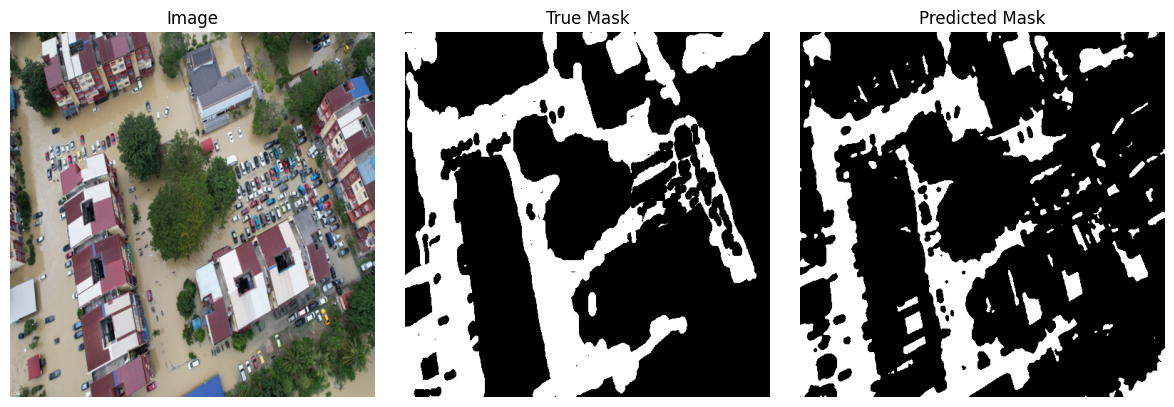

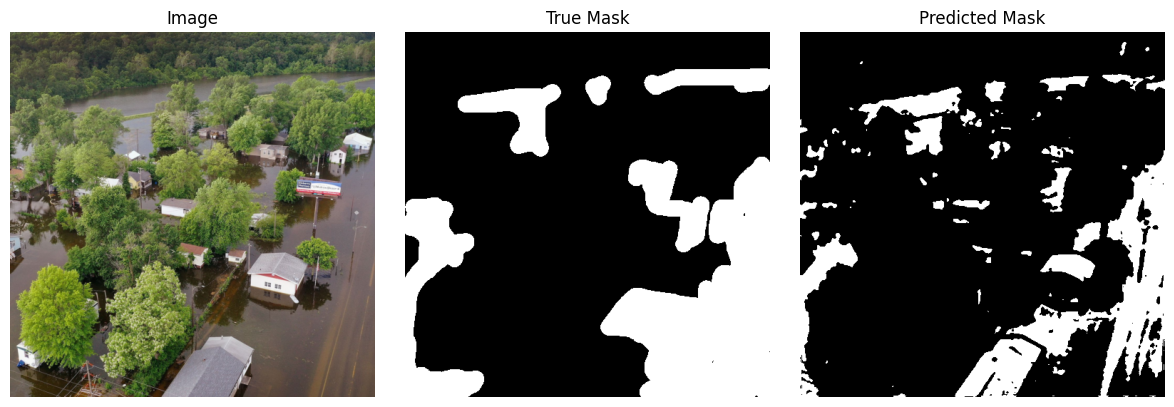

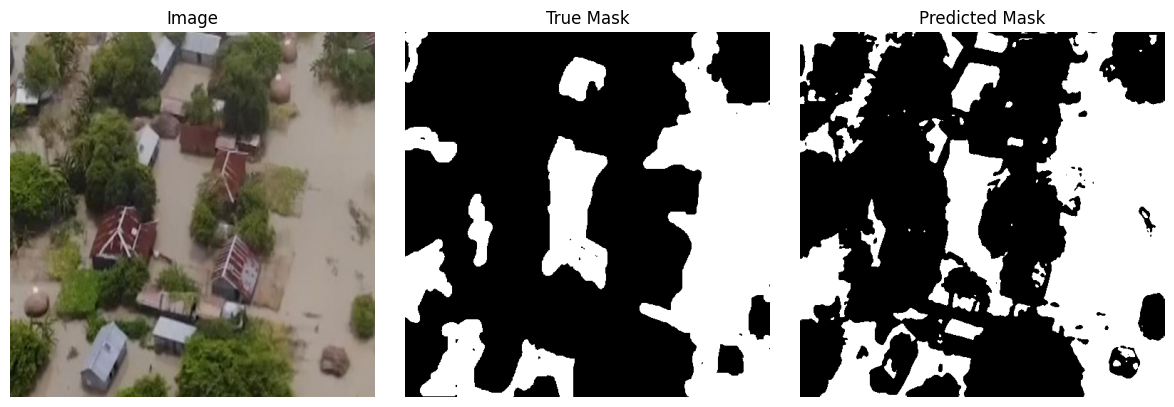

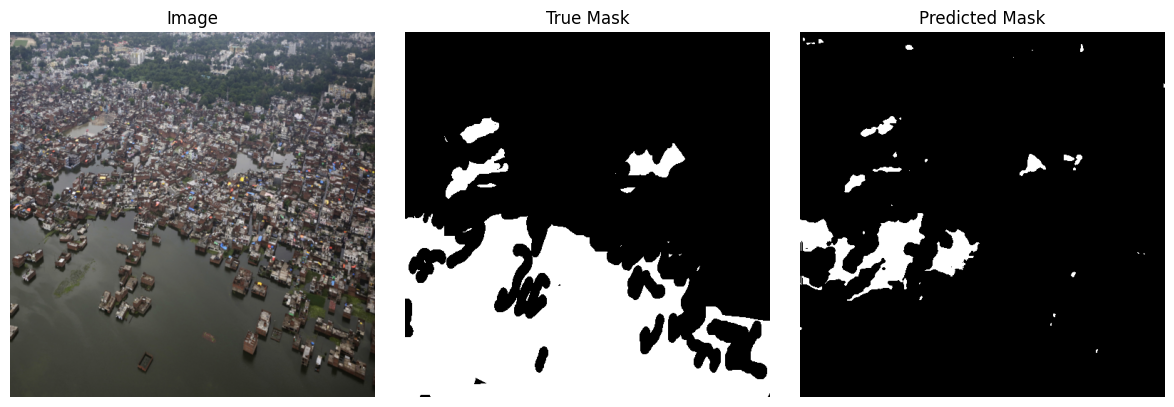

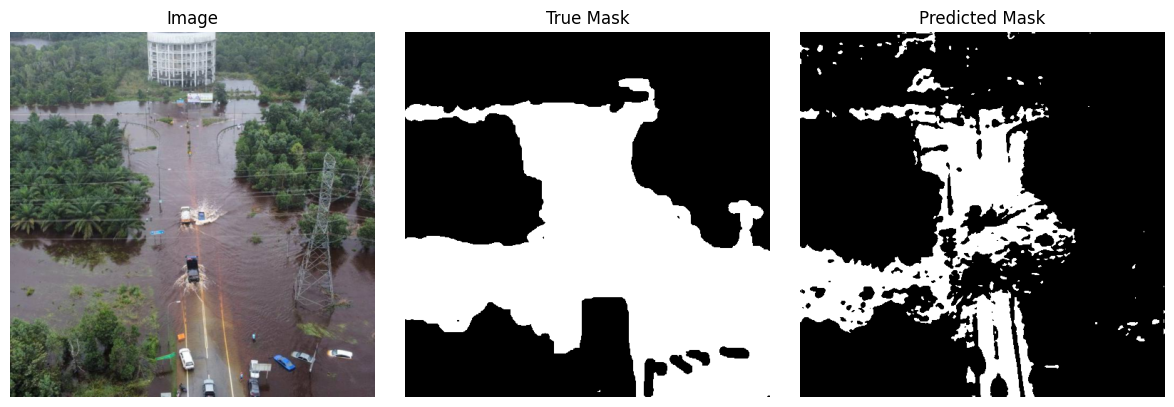

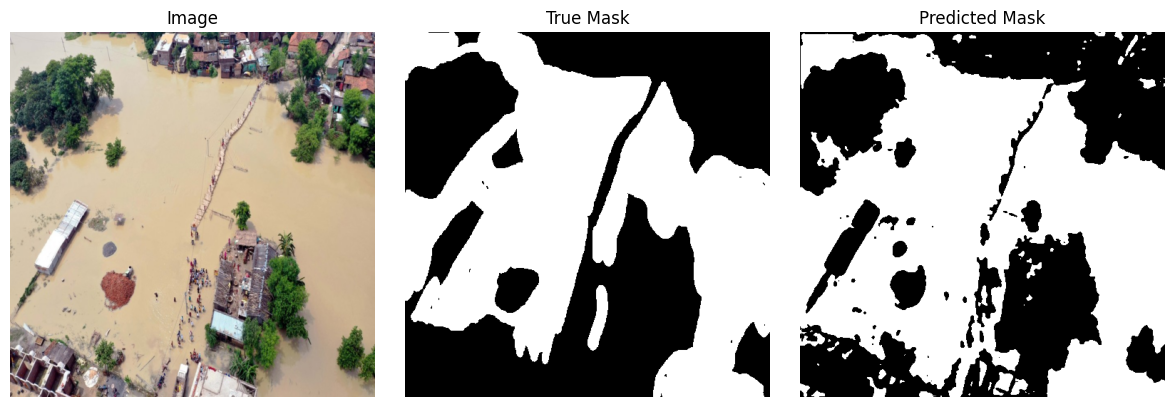

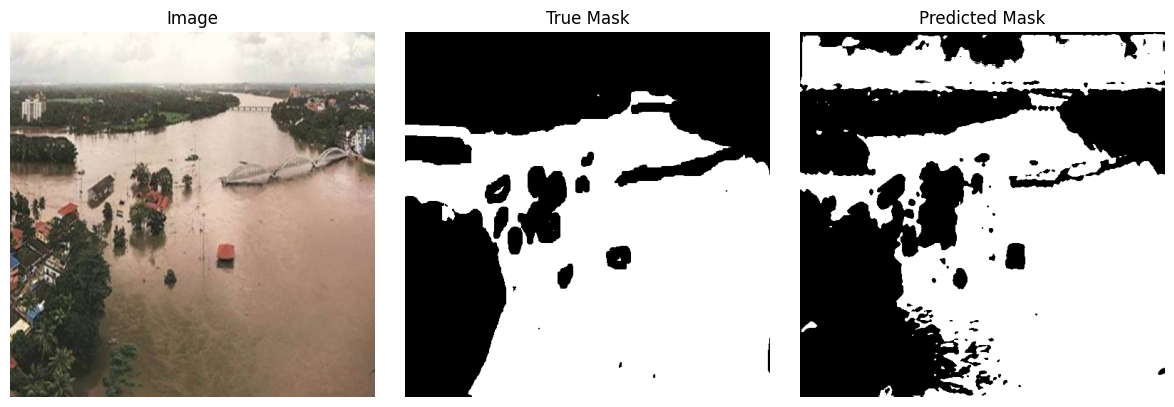

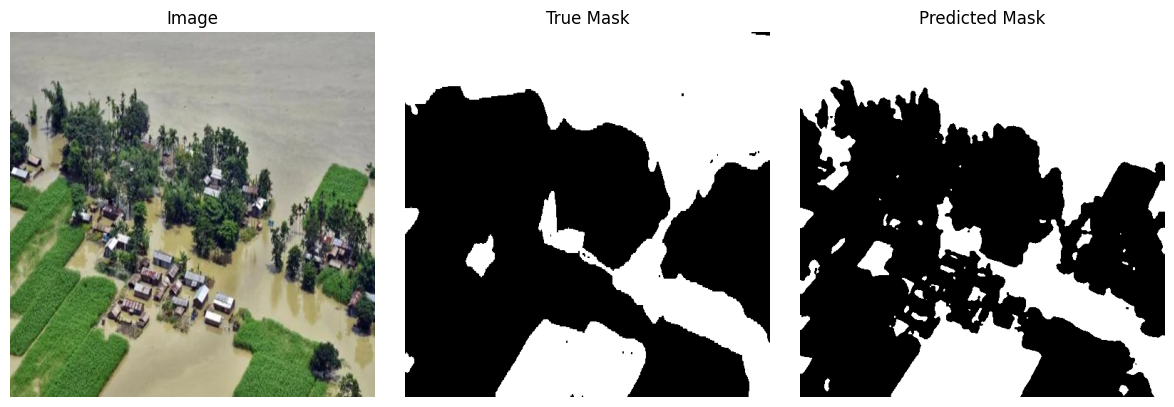

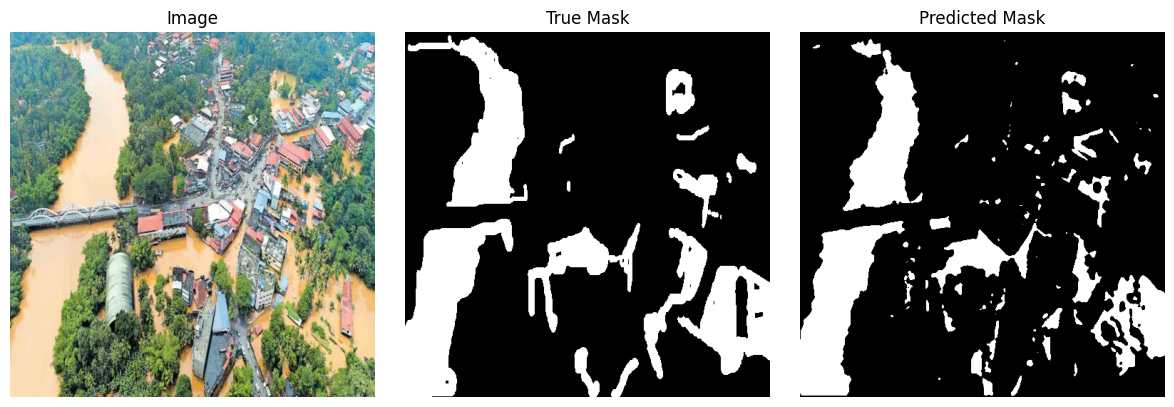

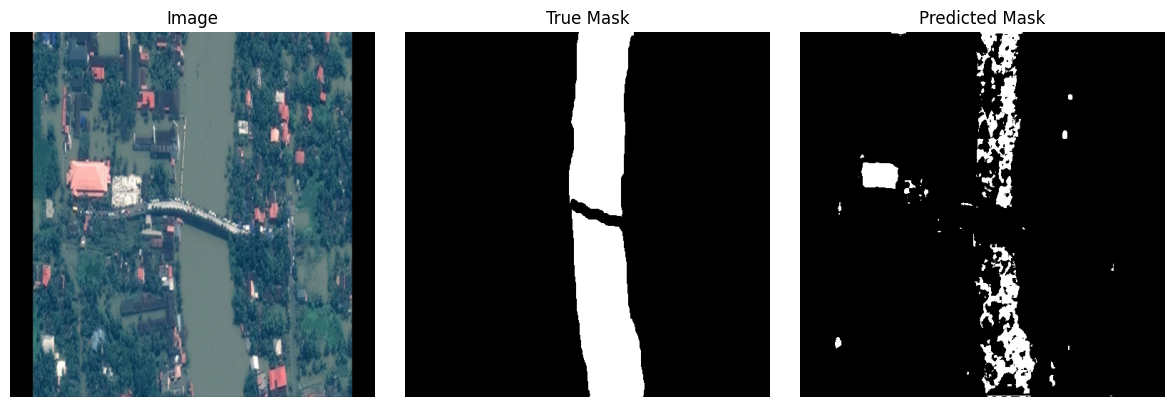

In [7]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
from dataset import FloodAreaDataset

# Function to denormalize images
def denormalize_tensor(image, mean = (0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    for t, m, s in zip(image, mean, std):
        t.mul_(s).add_(m)
    return image

# Function to plot examples with predicted and true masks
def plot_examples(model, dataset, num_examples=5):
    model.eval()
    
    for i in range(num_examples):
        image, mask = dataset[i]
        
        with torch.no_grad():
            output = model(image.unsqueeze(0).to(device)).cpu()
        
        pred_mask = torch.argmax(output, dim=1)
        
        # Plot the images and masks
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 3, 1)
        plt.imshow(denormalize_tensor(image).permute(1,2,0))
        plt.axis("off")
        plt.title('Image')
        
        plt.subplot(1, 3, 2)
        plt.imshow(mask.permute(1,2,0), cmap='gray')
        plt.axis("off")
        plt.title('True Mask')
        
        plt.subplot(1, 3, 3)
        plt.imshow(pred_mask.permute(1,2,0), cmap='gray')
        plt.axis("off")
        plt.title('Predicted Mask')
        
        plt.tight_layout()
        plt.show()

# Plot examples from the test dataloader

plot_examples(res_unet, test_dataset, num_examples=10)